/tmp/ipython-input-3111757836.py:105: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask = (np.abs(X) == 1) | (np.abs(Y) == 1)


Epoch     0 | PDE loss = 7.908e+01 | BC loss = 1.763e+00
Epoch   500 | PDE loss = 2.672e+00 | BC loss = 2.262e-04
Epoch  1000 | PDE loss = 8.042e-01 | BC loss = 1.439e-03
Epoch  1500 | PDE loss = 6.065e-01 | BC loss = 8.426e-04
Epoch  2000 | PDE loss = 3.917e-01 | BC loss = 4.705e-04
Epoch  2500 | PDE loss = 5.456e-01 | BC loss = 9.762e-05
Epoch  3000 | PDE loss = 1.360e-01 | BC loss = 3.811e-04
Epoch  3500 | PDE loss = 1.438e-01 | BC loss = 1.770e-04
Epoch  4000 | PDE loss = 4.761e-01 | BC loss = 1.467e-04
Epoch  4500 | PDE loss = 9.300e-01 | BC loss = 2.279e-04
Epoch  5000 | PDE loss = 7.990e-01 | BC loss = 9.102e-05
Epoch  5500 | PDE loss = 2.147e+00 | BC loss = 1.085e-04
Epoch  6000 | PDE loss = 9.643e-02 | BC loss = 1.540e-05
Epoch  6500 | PDE loss = 4.992e-01 | BC loss = 3.074e-05
Epoch  7000 | PDE loss = 1.913e-01 | BC loss = 2.721e-05
Epoch  7500 | PDE loss = 1.289e-01 | BC loss = 1.124e-05


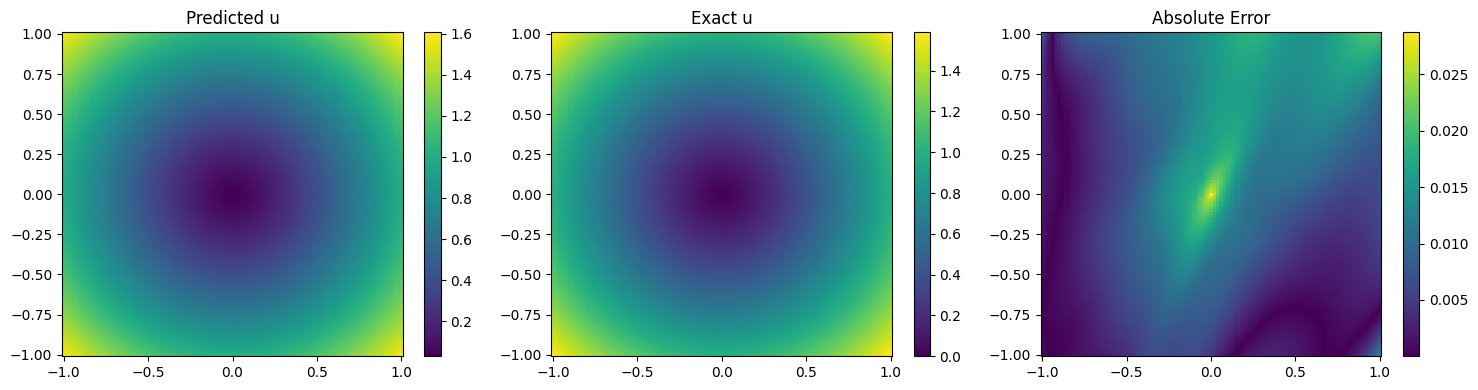

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. 基本设置
# ======================
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练区域 [-1, 1]^2
lb = torch.tensor([-1.0, -1.0]).to(device)
ub = torch.tensor([1.0, 1.0]).to(device)

# 各向异性系数矩阵 A
A = torch.tensor([[1.0, 2.0],
                  [2.0, 5.0]], dtype=torch.float64).to(device)

# ======================
# 2. 精确解与右端项
# ======================
def u_exact(x, y):
    return (x**2 + y**2)**(2/3)

def f_exact(x, y):
    return 32 * (2*x**2 + y**2 - x*y) / (9 * (x**2 + y**2)**(4/3))

# ======================
# 3. PINN 网络结构
# ======================
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

# 网络配置
layers = [2, 128, 128, 128, 1]
model = MLP(layers).to(device)

# ======================
# 4. 物理残差定义
# ======================
def pde_residual(xy):
    xy.requires_grad_(True)
    u = model(xy)

    grads = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True)[0]
    ux = grads[:, 0:1]
    uy = grads[:, 1:2]

    # A∇u
    Agrad = torch.cat([A[0,0]*ux + A[0,1]*uy,
                       A[1,0]*ux + A[1,1]*uy], dim=1)

    div_term = []
    for i in range(2):
        grad_Aui = torch.autograd.grad(Agrad[:, i], xy, torch.ones_like(Agrad[:, i]), create_graph=True)[0]
        div_term.append(grad_Aui[:, i:i+1])
    div_Agrad = sum(div_term)

    f_val = f_exact(xy[:, 0:1], xy[:, 1:2])
    return div_Agrad - f_val

# ======================
# 5. 采样点
# ======================
# 方案一：修改内部采样函数，避开原点
def sample_interior(n):
    # 多采样一些点，以便之后筛选
    n_oversample = int(n * 1.5)
    xy = torch.rand((n_oversample, 2), dtype=torch.float64).to(device)
    xy = lb + (ub - lb) * xy

    # 计算到原点的距离
    r = torch.sqrt(xy[:,0]**2 + xy[:,1]**2)

    # 定义一个要避开的半径
    epsilon = 0.01

    # 保留半径外的点
    xy_filtered = xy[r > epsilon]

    # 如果筛选后点不够，就取前n个
    if xy_filtered.shape[0] >= n:
        return xy_filtered[:n, :]
    else:
        # 如果点太少（n很大或epsilon很大），就直接返回筛选结果
        return xy_filtered

def sample_boundary(n):
    x = torch.linspace(-1, 1, n)
    y = torch.linspace(-1, 1, n)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    X, Y = X.flatten(), Y.flatten()
    # 边界上的点
    mask = (np.abs(X) == 1) | (np.abs(Y) == 1)
    xb = torch.tensor(np.vstack((X[mask], Y[mask])).T, dtype=torch.float64).to(device)
    ub_val = u_exact(xb[:,0:1], xb[:,1:2])
    return xb, ub_val

# ======================
# 6. 损失函数
# ======================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 新增一个学习率调度器，有助于后期微调
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

# 定义边界损失的权重
lambda_bc = 100.0  # <--- 关键在这里！这个值可以设为 10, 100, 甚至 1000

for epoch in range(8000):
    optimizer.zero_grad()

    xy_f = sample_interior(2000) # 建议同时使用上个回答中避开奇点的采样方法
    xy_b, u_b = sample_boundary(200)

    # PDE残差损失
    res = pde_residual(xy_f)
    loss_pde = torch.mean(res**2)

    # 边界损失
    u_pred_b = model(xy_b)
    loss_bc = torch.mean((u_pred_b - u_b)**2)

    # ==========================================================
    #                  核心修改：带权重的总损失
    # ==========================================================
    loss = loss_pde + lambda_bc * loss_bc

    loss.backward()
    optimizer.step()
    scheduler.step() # 在每个epoch后更新学习率

    if epoch % 500 == 0:
        # 在打印时，我们可以看原始的BC loss和加权后的BC loss，以作对比
        print(f"Epoch {epoch:5d} | PDE loss = {loss_pde.item():.3e} | BC loss = {loss_bc.item():.3e}")

# ======================
# 7. 可视化结果
# ======================
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T, dtype=torch.float64).to(device)

with torch.no_grad():
    U_pred = model(XY).cpu().numpy().reshape(101, 101)
    U_true = u_exact(XY[:,0], XY[:,1]).cpu().numpy().reshape(101, 101)
    error = np.abs(U_pred - U_true)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Predicted u")
plt.pcolormesh(X, Y, U_pred, shading='auto'); plt.colorbar()

plt.subplot(1,3,2)
plt.title("Exact u")
plt.pcolormesh(X, Y, U_true, shading='auto'); plt.colorbar()

plt.subplot(1,3,3)
plt.title("Absolute Error")
plt.pcolormesh(X, Y, error, shading='auto'); plt.colorbar()

plt.tight_layout()
plt.show()
